
# File Conversions
The goal of this notebook is to demonstrate how to load model output in a csv file and convert it to a NetCDF that the model output could be augmented as described in other insight patterns notebooks.

First:

```
# download files from S3
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/sample.csv

```

The above shell commands will download a sample .csv file of sea surface temperature.


### Requirements
```
matplotlib==3.4.2
netCDF4==1.5.7
numpy==1.20.3
pandas==1.3.3
seaborn==0.11.1
xarray==0.18.2
```



In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

### Load sample.csv and examine dataframe


In [4]:
df = pd.read_csv('sample.csv', index_col=False)
df

,lon,lat,time,tos
0,1.0,-79.5,2001-01-16 00:00:00,NaN
1,1.0,-79.5,2001-02-16 00:00:00,NaN
2,1.0,-79.5,2001-03-16 00:00:00,NaN
3,1.0,-79.5,2001-04-16 00:00:00,NaN
4,1.0,-79.5,2001-05-16 00:00:00,NaN
...,...,...,...,...
734395,359.0,89.5,2002-08-16 00:00:00,271.45760
734396,359.0,89.5,2002-09-16 00:00:00,271.49920
734397,359.0,89.5,2002-10-16 00:00:00,271.49005
734398,359.0,89.5,2002-11-16 00:00:00,271.47504


### Plot a time point of the data frame.

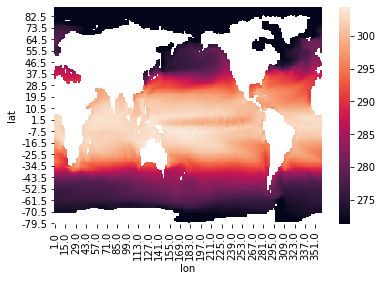

In [5]:
df3 = df[df['time'] == '2001-04-16 00:00:00']
df3 = df3[['lon', 'lat', 'tos']]
table = df3.pivot('lat', 'lon', 'tos')
ax = sns.heatmap(table)
ax.invert_yaxis()
plt.show()

### Create numpy arrays of each column and compare sizes.
In order to create a NetCDF, the product of the unique coordinate counts must equal the number of variable observations. Here we get the number of unique longitude, latitude, and time values, and also the total number of observations. For CSV files that are not symetrical, missing coordinate or variable values would have to be filled in.

In [6]:
lon = df['lon'].unique()
lat = df['lat'].unique()
time = df['time'].unique()
tos = df['tos'].to_numpy()
print('lon count: ', len(lon))
print('lat count: ', len(lat))
print('time count: ', len(time))
print('tos count: ', len(tos))
print('Product of lat/lon/time counts:', len(lon) * len(lat) * len(time))

lon count:  180
lat count:  170
time count:  24
tos count:  734400
Product of lat/lon/time counts: 734400


### DateTime special handling
The date/time array needs special treatment beacause it will usually be of string or object type. 
It should be a datetime to create the NetCDF dataset.

In [7]:
print('before:', type(time[0]))
time = time.astype(np.datetime64)
print('after:',type(time[0]))

before: <class 'str'>
after: <class 'numpy.datetime64'>


### Create the NetCDF Dataset
The TOS numpy array must be reshaped to match the unique counts of the coordinates lat, lon, time in the proper order using the lengths show above:
```tos.reshape(170, 180, 24)```
Here we create and plot the dataset.

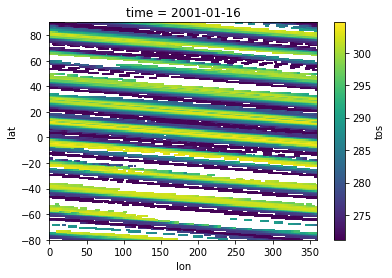

In [8]:
tos_reshaped = np.reshape(tos, (170, 180, 24), order='C')
ds = xr.Dataset(   
    data_vars=
    {
      "tos": ( ("lat", "lon", "time"), tos_reshaped )  
    },    
    coords = 
    {
        "time": time, "lat": lat, "lon": lon
    },
    attrs=
    {
        'description': 'Surface temperature',
        'original_file': 'sample1.csv',
        'references': 'Dufresne et al, Journal of Climate, 2015, vol XX, p 136',
    }    
)
ds.tos[:,:,0].plot()

### That doesn't look right.
The dataframe of the loaded csv file shows the column order as lon, lat, time; but, we reshaped the numpy array in lat, lon, time order. Here, we reorder the values for np.reshape and the data_vars.

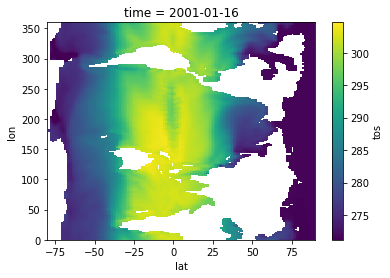

In [9]:
tos_reshaped = np.reshape(tos, (180, 170, 24), order='C')
ds = xr.Dataset(   
    data_vars=
    {
      "tos": ( ("lon", "lat", "time"), tos_reshaped )  
    },    
    coords = 
    {
        "time": time, "lat": lat, "lon": lon
    },
    attrs=
    {
        'description': 'Surface temperature',
        'original_file': 'sample1.csv',
        'references': 'Dufresne et al, Journal of Climate, 2015, vol XX, p 136',
    }    
)
ds.tos[:,:,0].plot()

### Close, but not quite.
The NetCDF dataset is plotting lat on the x instead of y axis. We can fix this by transposing the dataset.

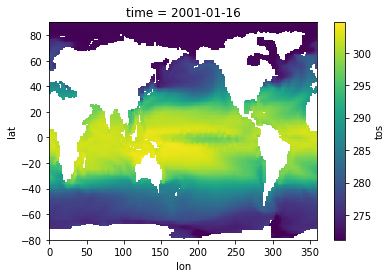

In [10]:
ds_t = ds.transpose()
ds_t.tos[0,:,:].plot()

### Saving the new NetCDF
The file can now be saved and imported into another insight patterns notebook.

In [11]:
ds_t.to_netcdf("new_netcdf_file.nc")